In [44]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm
from sklearn import cluster
from sklearn import preprocessing


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 10000
stock = '13003'
K = 50
r = 0.01
s = 0.05
Kn = 10

In [41]:
filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, data_length, r, s, K)
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=data_length)
gdf_columns = ['gdf_' + str(i) for i in range(0, Kn)]
dfs.drop(columns=['gdf_' + str(i) for i in range(Kn, K)], inplace=True)
dfs_cv.drop(columns=['gdf_' + str(i) for i in range(Kn, K)], inplace=True)
dfs_test.drop(columns=['gdf_' + str(i) for i in range(Kn, K)], inplace=True)
dfs.dropna(inplace=True)
dfs_cv.dropna(inplace=True)
dfs_test.dropna(inplace=True)

In [46]:
scaler = preprocessing.StandardScaler().fit(dfs[['mid_price_norm']])
dfs['mid_price_norm'] = scaler.transform(dfs[['mid_price']])
dfs_cv['mid_price_norm'] = scaler.transform(dfs_cv[['mid_price']])
dfs_test['mid_price_norm'] = scaler.transform(dfs_test[['mid_price']])


In [47]:
dfs.head()


,Unnamed: 0,gdf_0,gdf_1,gdf_2,gdf_3,gdf_4,gdf_5,gdf_6,gdf_7,gdf_8,gdf_9,mid_price,mid_price_indicator,mid_price_norm
2000,2000,1.319139e-12,1.518416e-07,5.901544e-04,0.018625,0.018625,0.001308,0.000002,0.002328,0.003312,0.003540,419.90,0.0,418.90
2001,2001,8.658085e-07,8.281100e-12,2.045912e-08,0.000169,0.012383,0.012383,0.003588,0.000004,0.000794,0.004694,419.85,1.0,418.85
2002,2002,4.815543e-03,5.149962e-03,5.739964e-03,0.015714,0.015604,0.001308,0.000002,0.002328,0.008344,0.008573,419.90,1.0,418.90
2003,2003,6.462500e-03,8.247887e-03,7.137189e-03,0.007111,0.000414,0.000008,0.005911,0.008189,0.008965,0.001380,419.95,0.0,418.95
2004,2004,4.815543e-03,8.943943e-03,9.533946e-03,0.012107,0.012038,0.004745,0.003439,0.005764,0.008409,0.008620,419.90,1.0,418.90


## Visualization

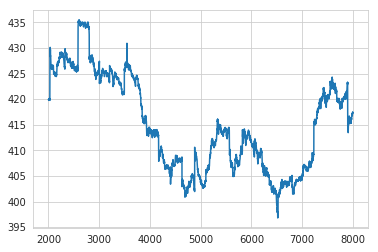

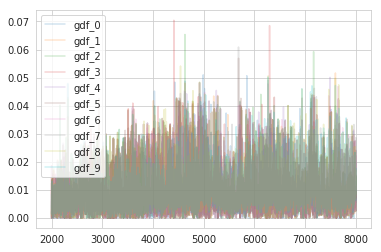

In [14]:
dfs['mid_price'].plot()

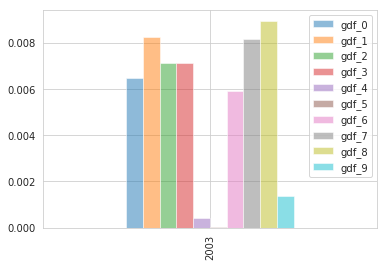

In [28]:
dfs.iloc[3:4][gdf_columns].plot(alpha=0.5, kind='bar')

## GDF clustering

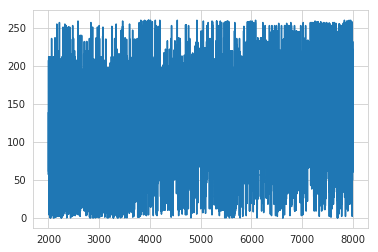

In [5]:
aff = cluster.AffinityPropagation()
a = aff.fit_predict(dfs.loc[:, gdf_columns])
dfs['a'] = a
dfs['a'].plot()

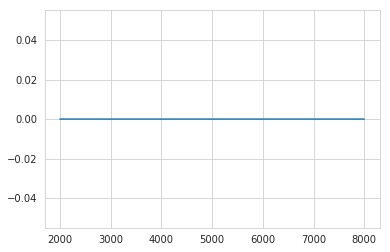

In [6]:
birch = cluster.Birch()
b = birch.fit_predict(dfs.loc[:, gdf_columns])
dfs['b'] = b
dfs['b'].plot()

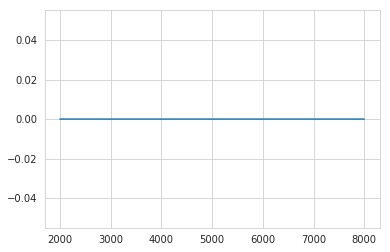

In [7]:
mean_shift = cluster.MeanShift(bandwidth=5)
m = birch.fit_predict(dfs.loc[:, gdf_columns])
dfs['mean_shift'] = m
dfs['mean_shift'].plot()

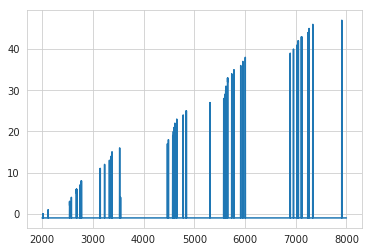

In [8]:
db_scan = cluster.DBSCAN(algorithm='auto', eps=0.0005, leaf_size=100, metric='l2', 
                         metric_params=None, min_samples=2, n_jobs=None, p=None)
db = db_scan.fit_predict(dfs.loc[:, gdf_columns])
dfs['db'] = db
dfs['db'].plot()

In [9]:
len(dfs['a'].unique()), len(dfs)

(261, 6000)

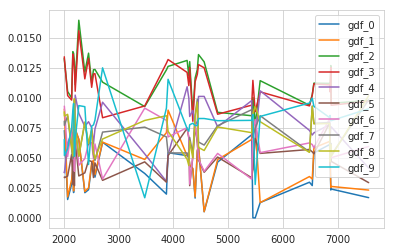

In [31]:
dfs[dfs['a'] == 10][gdf_columns].plot()

In [11]:
## TODO: let's look if there is a pattern for which the stock market rises

## Clustering mid price

In [32]:
dfs.columns

Index(['Unnamed: 0', 'gdf_0', 'gdf_1', 'gdf_2', 'gdf_3', 'gdf_4', 'gdf_5',
       'gdf_6', 'gdf_7', 'gdf_8', 'gdf_9', 'mid_price', 'mid_price_indicator',
       'a', 'b', 'mean_shift', 'db'],
      dtype='object')

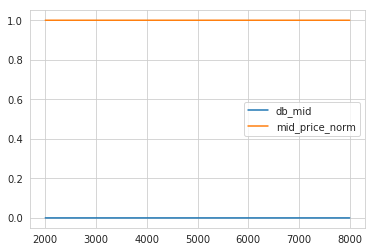

In [39]:
db_mid_scan = cluster.DBSCAN(algorithm='auto', eps=0.0005, leaf_size=100, metric='l2', 
                         metric_params=None, min_samples=2, n_jobs=None, p=None)
db_mid = db_mid_scan.fit_predict(dfs.loc[:, ['mid_price_norm']])
dfs['db_mid'] = db_mid
dfs[['db_mid', 'mid_price_norm']].plot()